# The Bahdanau Attention Mechanism

![seq_state](image/seq2seq-state.svg)

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

## Model

![seq_attention](image/seq2seq-details-attention.svg)

$$
\mathbf{c}_{t'} = \sum_{t=1}^{T} \alpha(\mathbf{s}_{t' - 1}, \mathbf{h}_{t}) \mathbf{h}_{t}.
$$

We used $\mathbf{s}_{t' - 1}$ as the query, and $\mathbf{h}_{t}$ as both the key and the value. Note that $\mathbf{c}_{t'}$ is then used to generate the state $\mathbf{s}_{t'}$ and to generate a new token.
- $\alpha$ is the attention scoring function, we use additive attention here.

## Decoder

In [2]:
class AttentionDecoder(d2l.Decoder):  #@save
    """The base attention-based decoder interface."""
    def __init__(self):
        super().__init__()

    @property
    def attention_weights(self):
        raise NotImplementedError

In [3]:
from attention import AdditiveAttention

class Seq2SeqAttentionDecoder(AttentionDecoder):
    def __init__(
            self, 
            vocab_size, 
            embed_size, 
            num_hiddens, 
            num_layers,
            dropout=0
        ):
        super().__init__()
        self.attention = AdditiveAttention(
            num_hiddens, 
            dropout
        )
        self.embedding = nn.Embedding(
            vocab_size, 
            embed_size
        )
        self.rnn = nn.GRU(
            embed_size + num_hiddens, 
            num_hiddens, num_layers,
            dropout=dropout
        )
        self.dense = nn.LazyLinear(vocab_size)

    def init_state(self, enc_outputs, enc_valid_lens):
        # Shape of outputs: (num_steps, batch_size, num_hiddens).
        # Shape of hidden_state: (num_layers, batch_size, num_hiddens)
        outputs, hidden_state = enc_outputs
        return (outputs.permute(1, 0, 2), hidden_state, enc_valid_lens)

    def forward(self, X, state):
        # Shape of enc_outputs: (batch_size, num_steps, num_hiddens).
        # Shape of hidden_state: (num_layers, batch_size, num_hiddens)
        enc_outputs, hidden_state, enc_valid_lens = state
        # Shape of the output X: (num_steps, batch_size, embed_size)
        X = self.embedding(X).permute(1, 0, 2)
        outputs, self._attention_weights = [], []
        for x in X:
            # Shape of query: (batch_size, 1, num_hiddens)
            query = torch.unsqueeze(
                hidden_state[-1], 
                dim=1
            )
            # Shape of context: (batch_size, 1, num_hiddens)
            context = self.attention(
                query, 
                enc_outputs, 
                enc_outputs, 
                enc_valid_lens
            )
            # Concatenate on the feature dimension
            x = torch.cat((
                context, 
                torch.unsqueeze(x, dim=1)), 
                dim=-1
            )
            # Reshape x as (1, batch_size, embed_size + num_hiddens)
            out, hidden_state = self.rnn(
                x.permute(1, 0, 2), 
                hidden_state
            )
            outputs.append(out)
            self._attention_weights.append(
                self.attention.attention_weights
            )
        # After fully connected layer transformation, shape of outputs:
        # (num_steps, batch_size, vocab_size)
        outputs = self.dense(torch.cat(outputs, dim=0))
        return outputs.permute(1, 0, 2), [enc_outputs, hidden_state,
                                          enc_valid_lens]

    @property
    def attention_weights(self):
        return self._attention_weights

In [4]:
vocab_size, embed_size, num_hiddens, num_layers = 10, 8, 16, 2
batch_size, num_steps = 4, 7
encoder = d2l.Seq2SeqEncoder(
    vocab_size, 
    embed_size, 
    num_hiddens, 
    num_layers
)
decoder = Seq2SeqAttentionDecoder(
    vocab_size, 
    embed_size, 
    num_hiddens,
    num_layers
)
X = torch.zeros((batch_size, num_steps), dtype=torch.long)
state = decoder.init_state(encoder(X), None)
output, state = decoder(X, state)

/opt/data/private/linkdom/miniconda3/miniconda3/envs/conformer/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [5]:
output.shape == (batch_size, num_steps, vocab_size)

True

In [6]:
state[0].shape == (batch_size, num_steps, num_hiddens)

True

In [7]:
state[1][0].shape == (batch_size, num_hiddens)

True

## Train

loss 0.020, 7440.1 tokens/sec on cuda:0


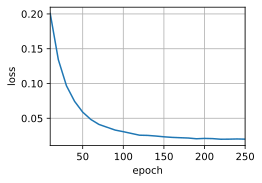

In [8]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 250, d2l.try_gpu()

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)
encoder = d2l.Seq2SeqEncoder(
    len(src_vocab), 
    embed_size, 
    num_hiddens, 
    num_layers, 
    dropout
)
decoder = Seq2SeqAttentionDecoder(
    len(tgt_vocab), 
    embed_size, 
    num_hiddens, 
    num_layers, 
    dropout
)
net = d2l.EncoderDecoder(encoder, decoder)
d2l.train_seq2seq(
    net, train_iter, lr, num_epochs, tgt_vocab, device
)

In [9]:
engs = [
    'go .', 
    "i lost .", 
    'he\'s calm .', 
    'i\'m home .'
]
fras = [
    'va !', 
    'j\'ai perdu .', 
    'il est calme .', 
    'je suis chez moi .'
]
for eng, fra in zip(engs, fras):
    translation, dec_attention_weight_seq = d2l.predict_seq2seq(
        net, eng, 
        src_vocab, tgt_vocab, 
        num_steps, device, True
    )
    print(f'{eng} => {translation}, ',
          f'bleu {d2l.bleu(translation, fra, k=2):.3f}')

go . => va !,  bleu 1.000
i lost . => j'ai perdu .,  bleu 1.000
he's calm . => c'est tom .,  bleu 0.000
i'm home . => je suis chez moi .,  bleu 1.000


In [11]:
dec_attention_weight_seq

[[tensor([[[0.0936, 0.4208, 0.2407, 0.2449, 0.0000, 0.0000, 0.0000, 0.0000,
            0.0000, 0.0000]]], device='cuda:0', grad_fn=<SoftmaxBackward0>)],
 [tensor([[[0.1081, 0.2278, 0.3358, 0.3283, 0.0000, 0.0000, 0.0000, 0.0000,
            0.0000, 0.0000]]], device='cuda:0', grad_fn=<SoftmaxBackward0>)],
 [tensor([[[0.0296, 0.0549, 0.4229, 0.4926, 0.0000, 0.0000, 0.0000, 0.0000,
            0.0000, 0.0000]]], device='cuda:0', grad_fn=<SoftmaxBackward0>)],
 [tensor([[[0.1118, 0.1709, 0.3515, 0.3658, 0.0000, 0.0000, 0.0000, 0.0000,
            0.0000, 0.0000]]], device='cuda:0', grad_fn=<SoftmaxBackward0>)],
 [tensor([[[0.0900, 0.0687, 0.4184, 0.4229, 0.0000, 0.0000, 0.0000, 0.0000,
            0.0000, 0.0000]]], device='cuda:0', grad_fn=<SoftmaxBackward0>)],
 [tensor([[[0.0980, 0.1336, 0.3383, 0.4302, 0.0000, 0.0000, 0.0000, 0.0000,
            0.0000, 0.0000]]], device='cuda:0', grad_fn=<SoftmaxBackward0>)]]

In [23]:
attention_weights = torch.cat(
    [step[0][0][0] for step in dec_attention_weight_seq], 0
).reshape((-1, num_steps))

In [24]:
attention_weights.shape

torch.Size([6, 10])

In [25]:
attention_weights

tensor([[0.0936, 0.4208, 0.2407, 0.2449, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.1081, 0.2278, 0.3358, 0.3283, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0296, 0.0549, 0.4229, 0.4926, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.1118, 0.1709, 0.3515, 0.3658, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0900, 0.0687, 0.4184, 0.4229, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0980, 0.1336, 0.3383, 0.4302, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000]], device='cuda:0', grad_fn=<ViewBackward0>)

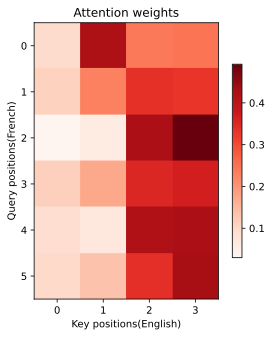

In [29]:
from attention import show_attention
# 加上一个包含序列结束词元
show_attention(
    attention=attention_weights[:,:len(engs[-1].split()) + 1].cpu(),
    xlabel='Key positions(English)',
    ylabel='Query positions(French)'
)